# Exercise in Concurrency

This is an exercise to help understand the usefulness of concurrency which is very important in supercomputering as we have very large numbers of computers working _concurrently_ on the same problem.

Here we'll start with an example of concurrency on a single computer CPU that has many cores.

## Loading the needed python modules

In [3]:
import concurrent.futures
import numpy as np
import json
from PIL import Image
from itertools import repeat
import multiprocessing
import time

## Retrieve ImageNet JPEG files

This is a helper function that returns a python list of image filenames.

In [4]:
def get_image_files(config_file='ilsvrc.json', num_images = 100):
   config = json.load(open(config_file))
   filelist = config['data']['train_filelist']
   
   with open(filelist) as myfile:
      image_filenames = [next(myfile).strip() for x in range(num_images)]
   
   return image_filenames

## Process Images

We will imagine we are building a training batch for machine learning using these JPEGs. This would typically require you to
1. open the file, 
2. read the data, 
3. resize the image to fit your neural network, and
4. add it to the list of inputs

This function does this for us.

In [5]:
def process_image(image_filename,resize_shape,batch_data,index):
   # arguments:
   #   image_filename = string giving the full path to the JPEG file to open
   #   resize_shape   = a two dimensional tuple defining the image size in our batch, 
   #                      example: (200,100) corresponding to (width,height)
   #   batch_data     = the numpy array that will hold our batch of images in a single  
   #                      object with indices: (batch, width, height, channels)
   #   index          = a unique batch ID number that corresponds to the first index of 
   #                      our batch array
   
   # use the PIL.Image object to open our JPEG
   image = Image.open(image_filename)  # <- PIL.Image Object
   
   # use the Image.resize function to 
   image = image.resize(resize_shape)  # <- PIL.Image Object
   # convert the image to a numpy array
   data = np.asarray(image)            # <- numpy array of shape (width,height,3)
   # this is a check:
   # some of our JPEGs are black & white, so they have no channel index
   # so this little snippet of code adds a channel index if needed
   if len(data.shape) == 2:
      tmp = np.zeros(data.shape + (3,))
      tmp[...,0] = data
      data = tmp
   
   # In order to copy our image, which currently has shape (width,height,3)
   #    into the batch data array which has shape (batch_size,width,height,3),
   #    we need to add an extra index to our data
   data = data[np.newaxis,...]         # <- numpy array of shape (1,width,height,3)
   # copy one JPEG image data into our batch of data, at the passed index
   batch_data[index,...] = data

Now we can create a _serial_, AKA a single-core process, that builds a batch of images for our ML training.

In [6]:
# define how many images are in our batch
batch_size = 1000
# define our resize shape
resize_width = 100
resize_height = 100
resize_shape = (resize_width,resize_height)
# retrieve batch_size worth of JPEG filenames
img_files = get_image_files(num_images=batch_size)
# create a numpy array that will hold our batch data
#     np.zero creates an array of the given shape
#     where all entries are set to zero
batch_data = np.zeros((batch_size,resize_width,resize_height,3))
start_time = time.time()
# loop over the image filenames and process each one.
for i,imagefile in enumerate(img_files):
   process_image(imagefile,resize_shape,batch_data,i)
end_time = time.time()
duration = end_time - start_time
print(f'duration: {duration:8.2f} seconds')
image_rate = batch_size / duration
print(f'images per second: {image_rate:8.2f}')

duration:     5.91 seconds
images per second:   169.21


The code above takes many seconds to execute and only uses 1 CPU-core to build our batch. We can speed this up using parallel threads, where each thread uses a different CPU core on our machine.

We can use Python to tell us how many CPU cores we have:

In [7]:
print('number of CPU cores on my machine: ',multiprocessing.cpu_count())

number of CPU cores on my machine:  256


Now we can rewrite the loop above using Python's `ThreadPoolExecutor` module where we specify the number of parallel threads to use and what each thread will execute. The `executor.map()` function runs a function we specify once per thread. We also must provide a list of arguments for each function call. The thread pool ENDS when it runs out of arguments to pass to the function.

In [11]:
# NEW: now we need to specify how many parallel threads to run:
num_threads = 128

# define how many images are in our batch
batch_size = 3000
# define our resize shape
resize_width = 100
resize_height = 100
resize_shape = (resize_width,resize_height)
# retrieve batch_size worth of JPEG filenames
img_files = get_image_files(num_images=batch_size)
# create a numpy array that will hold our batch data
#     np.zero creates an array of the given shape
#     where all entries are set to zero
new_image = np.zeros((batch_size,resize_width,resize_height,3))

start_time = time.time()
# NEW: this is a fancy way to create this 'executor' object that will launch and manage our parallel threads
with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
   # Here is where the actual threads are launched
   #   we pass the function each thread should call 'process_image'
   #   then we pass our input function arguments:
   #        img_files  -> a list of filenames (batch_size long)
   #        repeat(resize_shape) -> repeat will provide as many copies of the resize_shape as is needed
   #        repeat(new_image) -> repeat will provide as many copies of the new_image as is needed
   #        repeat(len(img_files)) -> repeat will provide as many copies of number of files as is needed
   results = executor.map(process_image, img_files,repeat(resize_shape), repeat(new_image),range(len(img_files)))

end_time = time.time()
duration = end_time - start_time
print(f'duration: {duration:8.2f} seconds')
image_rate = batch_size / duration
print(f'images per second: {image_rate:8.2f}')

duration:     2.07 seconds
images per second:  1451.64


In [13]:
# you can check the results of each thread using the list of "results" returned by the map
# though in our case, they should simply be None since our function has no return value
for result in results:
   if result is not None: print(result)


# Exersize Instructions

Play with the value of `num_threads` and note how it affects run time and throughput. How does the return value of `multiprocessing.cpu_count()`, that is, how does the number of CPU cores on your machine impact the throughput you can achieve?

In [23]:
running_time = np.zeros(8)
for i in range(8):
    num_threads = 2**(i+1)
    # define how many images are in our batch
    batch_size = 3000
    # define our resize shape
    resize_width = 100
    resize_height = 100
    resize_shape = (resize_width,resize_height)
    # retrieve batch_size worth of JPEG filenames
    img_files = get_image_files(num_images=batch_size)
    # create a numpy array that will hold our batch data
    #     np.zero creates an array of the given shape
    #     where all entries are set to zero
    new_image = np.zeros((batch_size,resize_width,resize_height,3))

    start_time = time.time()
    # NEW: this is a fancy way to create this 'executor' object that will launch and manage our parallel threads
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
       # Here is where the actual threads are launched
       #   we pass the function each thread should call 'process_image'
       #   then we pass our input function arguments:
       #        img_files  -> a list of filenames (batch_size long)
       #        repeat(resize_shape) -> repeat will provide as many copies of the resize_shape as is needed
       #        repeat(new_image) -> repeat will provide as many copies of the new_image as is needed
       #        repeat(len(img_files)) -> repeat will provide as many copies of number of files as is needed
       results = executor.map(process_image, img_files,repeat(resize_shape), repeat(new_image),range(len(img_files)))

    end_time = time.time()
    duration = end_time - start_time
    print(f'duration: {duration:8.2f} seconds')
    image_rate = batch_size / duration
    print(f'images per second: {image_rate:8.2f}')
    running_time[i] = duration


duration:     6.42 seconds
images per second:   467.42
duration:     3.11 seconds
images per second:   963.52
duration:     1.79 seconds
images per second:  1672.08
duration:     1.17 seconds
images per second:  2561.58
duration:     1.45 seconds
images per second:  2068.73
duration:     1.46 seconds
images per second:  2048.88
duration:     1.54 seconds
images per second:  1949.33
duration:     1.57 seconds
images per second:  1915.04


In [24]:
running_time_batch = np.zeros(8)
for i in range(8):
    num_threads = 16
    # define how many images are in our batch
    batch_size = 1000*(i+1)
    # define our resize shape
    resize_width = 100
    resize_height = 100
    resize_shape = (resize_width,resize_height)
    # retrieve batch_size worth of JPEG filenames
    img_files = get_image_files(num_images=batch_size)
    # create a numpy array that will hold our batch data
    #     np.zero creates an array of the given shape
    #     where all entries are set to zero
    new_image = np.zeros((batch_size,resize_width,resize_height,3))

    start_time = time.time()
    # NEW: this is a fancy way to create this 'executor' object that will launch and manage our parallel threads
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
       # Here is where the actual threads are launched
       #   we pass the function each thread should call 'process_image'
       #   then we pass our input function arguments:
       #        img_files  -> a list of filenames (batch_size long)
       #        repeat(resize_shape) -> repeat will provide as many copies of the resize_shape as is needed
       #        repeat(new_image) -> repeat will provide as many copies of the new_image as is needed
       #        repeat(len(img_files)) -> repeat will provide as many copies of number of files as is needed
       results = executor.map(process_image, img_files,repeat(resize_shape), repeat(new_image),range(len(img_files)))

    end_time = time.time()
    duration = end_time - start_time
    print(f'duration: {duration:8.2f} seconds')
    image_rate = batch_size / duration
    print(f'images per second: {image_rate:8.2f}')
    running_time_batch[i] = duration

duration:     0.41 seconds
images per second:  2454.53
duration:     0.89 seconds
images per second:  2234.68
duration:     1.17 seconds
images per second:  2574.33
duration:     1.65 seconds
images per second:  2420.41
duration:     2.00 seconds
images per second:  2505.75
duration:     2.43 seconds
images per second:  2467.12
duration:     2.82 seconds
images per second:  2481.78
duration:     3.14 seconds
images per second:  2546.77


In [25]:
running_time

array([6.4182632 , 3.11357164, 1.79417348, 1.17115092, 1.4501617 ,
       1.4642117 , 1.53898883, 1.56654644])

In [26]:
running_time_batch

array([0.40740991, 0.89498425, 1.16535211, 1.65261126, 1.99540854,
       2.43198514, 2.82055354, 3.14123511])

In [28]:
import matplotlib.pyplot as plt

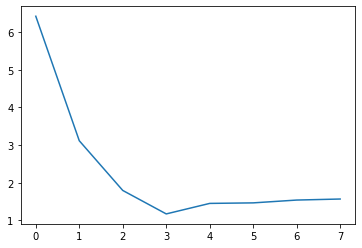

In [29]:
plt.plot(running_time)

run 1: num_threads = 5 batch = 1000   evt/s = 
run 2: num_threads = 